# Title - Milestone I

## 1) Import dependencies

### 1a) Install requirments.txt

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

### 1b) Import libraries

In [1]:
import os

import pandas as pd
from pyspark.sql import SparkSession
import numpy as np

import geopandas as gpd
from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from IPython.display import display
from PIL import Image

In [2]:
from src.zip_streaming import zip_streaming
from src.parcel_partition_write import parcel_partition_write
from src.parcel_partition_read import parcel_partition_read

from src.district_location import get_district_location
from src.school_location import get_school_location

from src.district_score import get_district_score
from src.school_score import get_school_score

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor

### 1b) Notebook toggles

In [4]:
regenerate_tables = False
regenerate_charts = True
random_state = 42

## 2) Run data pipeline

### 2a) Run CoreLogic data pipeline

In [5]:
required_files = ['resources/data/df_parcel.pkl']

partition_column = "PROPERTY INDICATOR CODE"
partition_value = "10"

if all(os.path.exists(file) for file in required_files) and regenerate_tables == False:
    print("✅ Required files found. Running secondary run...")
    df_parcel = pd.read_pickle("resources/data/df_parcel.pkl")

else:
    print("🚀 Required files not found. Running initial run...")

    ## Unzip and slice the orignal coreLogic dataset
    zip_streaming(zip_file_path = 'resources/data/coreLogic.zip', 
                 file_name_in_zip = 'coreLogic.txt',
                 output_path = 'resources/data/filtered_core_logic.txt',
                 chunk_size = 10000,
                 state = 'MI')

    ## Partition the coreLogic slice using Spark
    parcel_partition_write(input_file = 'resources/data/filtered_core_logic.txt', 
                           partition_column = partition_column)

    ## Load selected partition into Pandas DataFrame and format as GeoDataFrame
    df_parcel = parcel_partition_read(partition_folder = f"resources/data/parition_{partition_column}",
                                     partition_value = partition_value,
                                     pkl_path = 'resources/data/df_parcel.pkl',
                                     pkl_save = True)

    print("✅ Initial run complete. Required files should now be saved.")


✅ Required files found. Running secondary run...


### 2b) Run education score data pipeline

In [6]:
required_files = ['resources/data/df_school_score.csv', 'resources/data/df_district_score.csv']
input_files = {'atrisk':'resources/data/At Risk Student file for Statewide, school year 2020-21.csv',
               'enrollment':'resources/data/College Enrollment by High School & 24 College Credits file for Statewide, school year 2020-21.csv',
               'assessment':'resources/data/High School Assessments file for Statewide, school year 2020-21.csv', 
               'effectiveness':'resources/data/Educator Effectiveness file for Statewide, school year 2020-21.csv'}

if all(os.path.exists(file) for file in required_files) and regenerate_tables == False:
    print("✅ Required files found. Running secondary run...")
    df_school_score = pd.read_csv("resources/data/df_school_score.csv")
    df_district_score = pd.read_csv("resources/data/df_district_score.csv")

elif all(os.path.exists(file) for file in input_files.values()):
    print("🚀 Required files not found. Running initial run...")

    df_school_score = get_school_score(enrollment = input_files['enrollment'], 
                                       assessment  = input_files['assessment'],
                                       effectiveness  = input_files['effectiveness'],
                                       csv_path = 'resources/data/df_school_score.csv',
                                       csv_save = True)
    df_district_score = get_district_score(atrisk = input_files['atrisk'],
                                           enrollment = input_files['enrollment'],
                                           assessment = input_files['assessment'],
                                           csv_path = 'resources/data/df_district_score.csv',
                                           csv_save = True)

    print("✅ Initial run complete. Required files should now be saved.")
else:
    print("❌ Input files not found. Donwload input files or update input_files dictionary.")



🚀 Required files not found. Running initial run...
✅ Initial run complete. Required files should now be saved.


### 2c) Run location data pipeline

In [7]:
df_district_location = get_district_location()
df_school_location = get_school_location()

0 Schools in the list
0 Schools in the list
0 Schools in the list
47 Schools in the list
191 Schools in the list
152 Schools in the list
597 Schools in the list
263 Schools in the list
0 Schools in the list
0 Schools in the list
0 Schools in the list
8 Schools in the list
401 Schools in the list
177 Schools in the list
380 Schools in the list
258 Schools in the list
0 Schools in the list
0 Schools in the list
0 Schools in the list
25 Schools in the list
51 Schools in the list
88 Schools in the list
103 Schools in the list
21 Schools in the list
0 Schools in the list
0 Schools in the list
0 Schools in the list
6 Schools in the list
67 Schools in the list
36 Schools in the list
24 Schools in the list
0 Schools in the list
0 Schools in the list
0 Schools in the list
25 Schools in the list
10 Schools in the list
5 Schools in the list
40 Schools in the list
6 Schools in the list
0 Schools in the list
4 Schools in the list
4 Schools in the list
24 Schools in the list
6 Schools in the list
7 

## 3) Data wrangling & exploratory analysis

### 3z) Spatial check

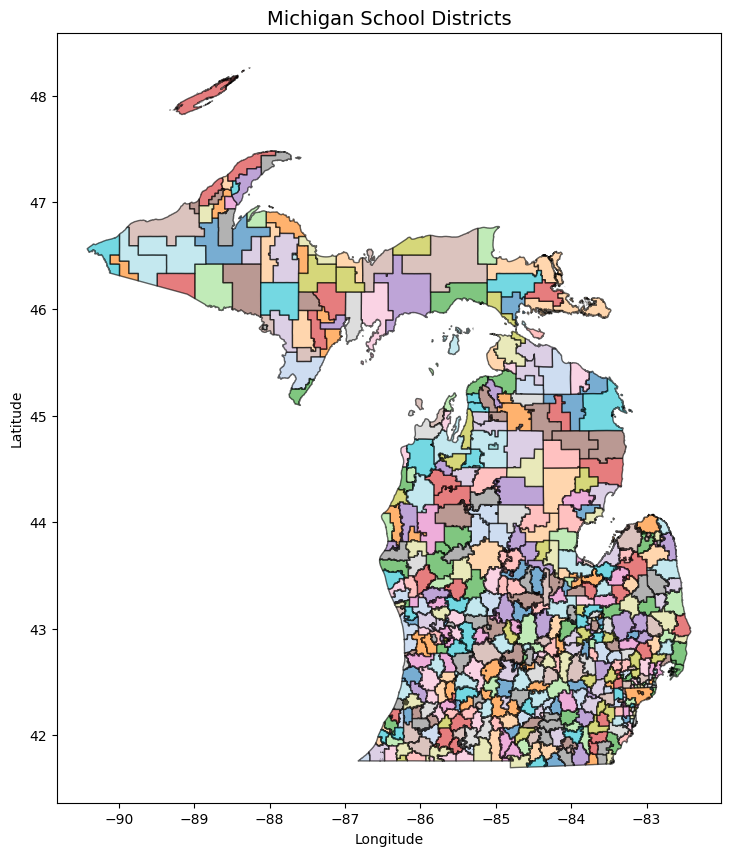

In [8]:
if regenerate_charts == True:
    fig, ax = plt.subplots(figsize=(10, 10))
    df_district_location.plot(ax=ax, edgecolor='black', cmap='tab20', alpha=0.6)
    
    ax.set_title("Michigan School Districts", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()
    fig.savefig("resources/charts/michigan_school_districts.png", dpi=500)
else:
    img = Image.open("resources/charts/michigan_school_districts.png")
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)
    ax.axis("off")
    plt.show()

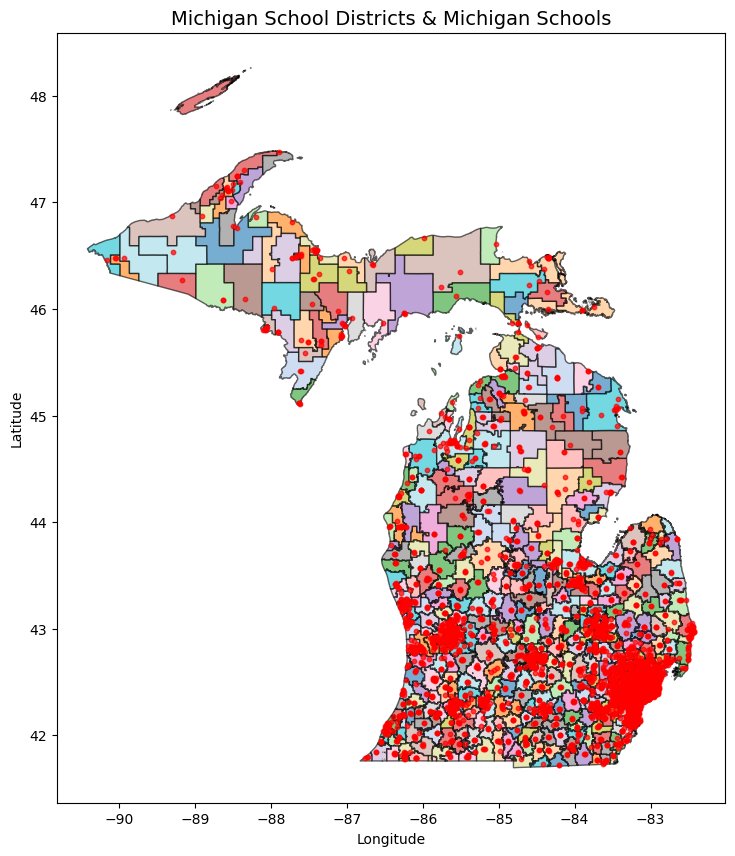

In [9]:
if regenerate_charts == True:
    fig, ax = plt.subplots(figsize=(10, 10))
    df_district_location.plot(ax=ax, edgecolor="black", cmap="tab20", alpha=0.6)
    df_school_location.plot(
        ax=ax, marker="o", color="red", markersize=10, alpha=0.7, label="Schools"
    )
    
    ax.set_title("Michigan School Districts & Michigan Schools", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    
    plt.show()
    fig.savefig("resources/charts/michigan_school_districts_and_schools.png", dpi=500)
else:
    img = Image.open("resources/charts/michigan_school_districts_and_schools.png")
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)
    ax.axis("off")
    plt.show()

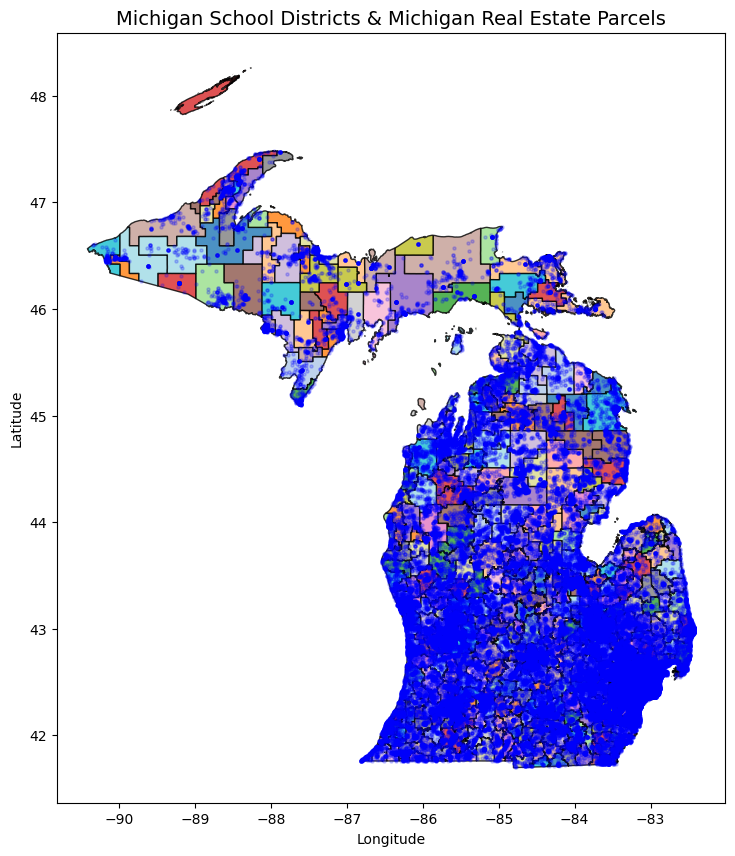

In [10]:
if regenerate_charts == True:
    fig, ax = plt.subplots(figsize=(10, 10))
    df_district_location.plot(ax=ax, edgecolor="black", cmap="tab20", alpha=0.8)
    df_parcel.sample(n = 100000, random_state = random_state).plot(
        ax=ax, marker="o", color="blue", markersize=5, alpha=0.2, label="Schools"
    )
    
    ax.set_title("Michigan School Districts & Michigan Real Estate Parcels", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    
    plt.show()
    fig.savefig("resources/charts/michigan_school_districts_and_parcels.png", dpi=500)
else:
    img = Image.open("resources/charts/michigan_school_districts_and_parcels.png")
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)
    ax.axis("off")
    plt.show()

### 3x) Table joins

In [11]:
df_school = df_school_location.merge(df_school_score, on='school_code', how='inner', suffixes=('', '_y')).drop(['school_name_y'],  axis=1)
df_district = df_district_location.merge(df_district_score, on='district_code', how='inner', suffixes=('', '_y'))

In [15]:
df_parcel = gpd.sjoin_nearest(df_parcel, df_school, how="left", distance_col="distance")

In [18]:
df_parcel = gpd.sjoin(df_parcel, df_district, predicate="within", how="left", lsuffix='school', rsuffix='dist')

### 3a) Missing values & Imputation

<Axes: >

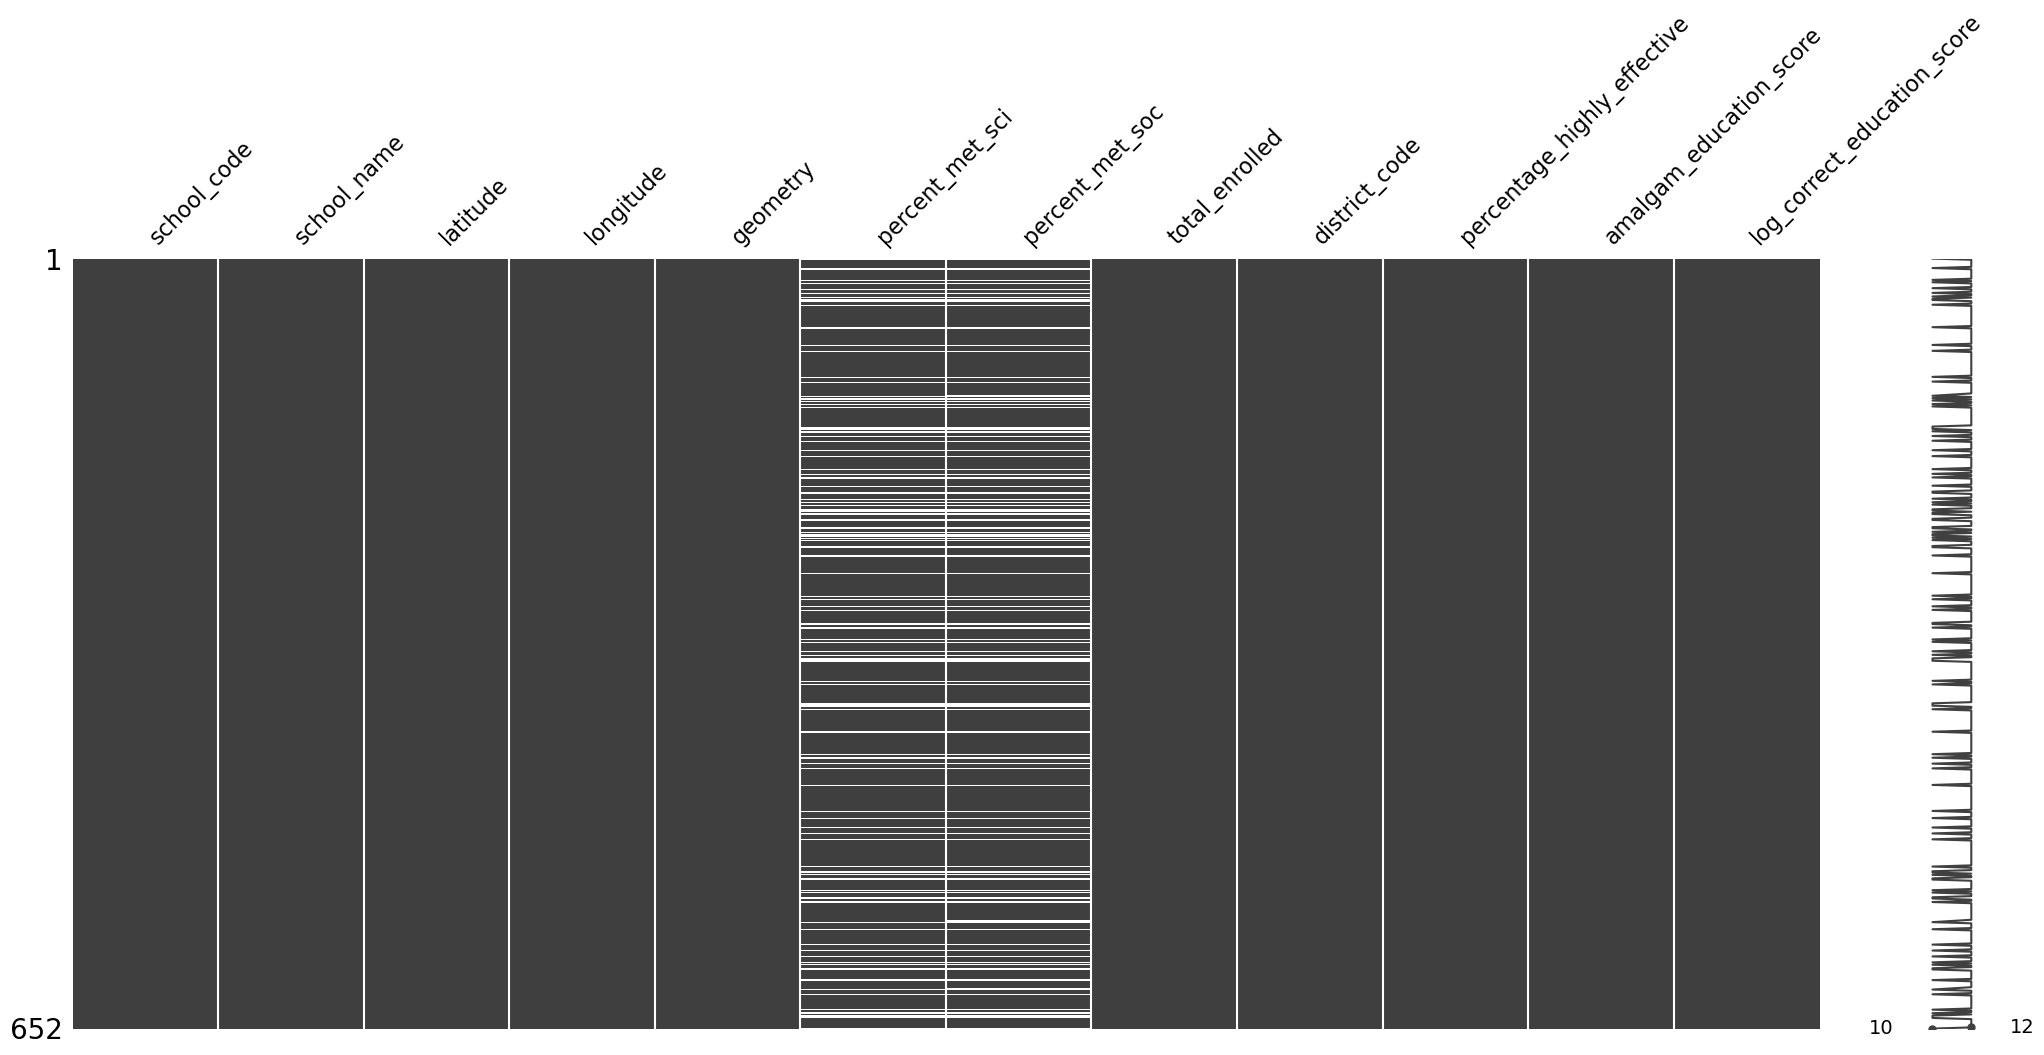

In [24]:
if regenerate_charts == True:
    msno.matrix(df_school)

<Axes: >

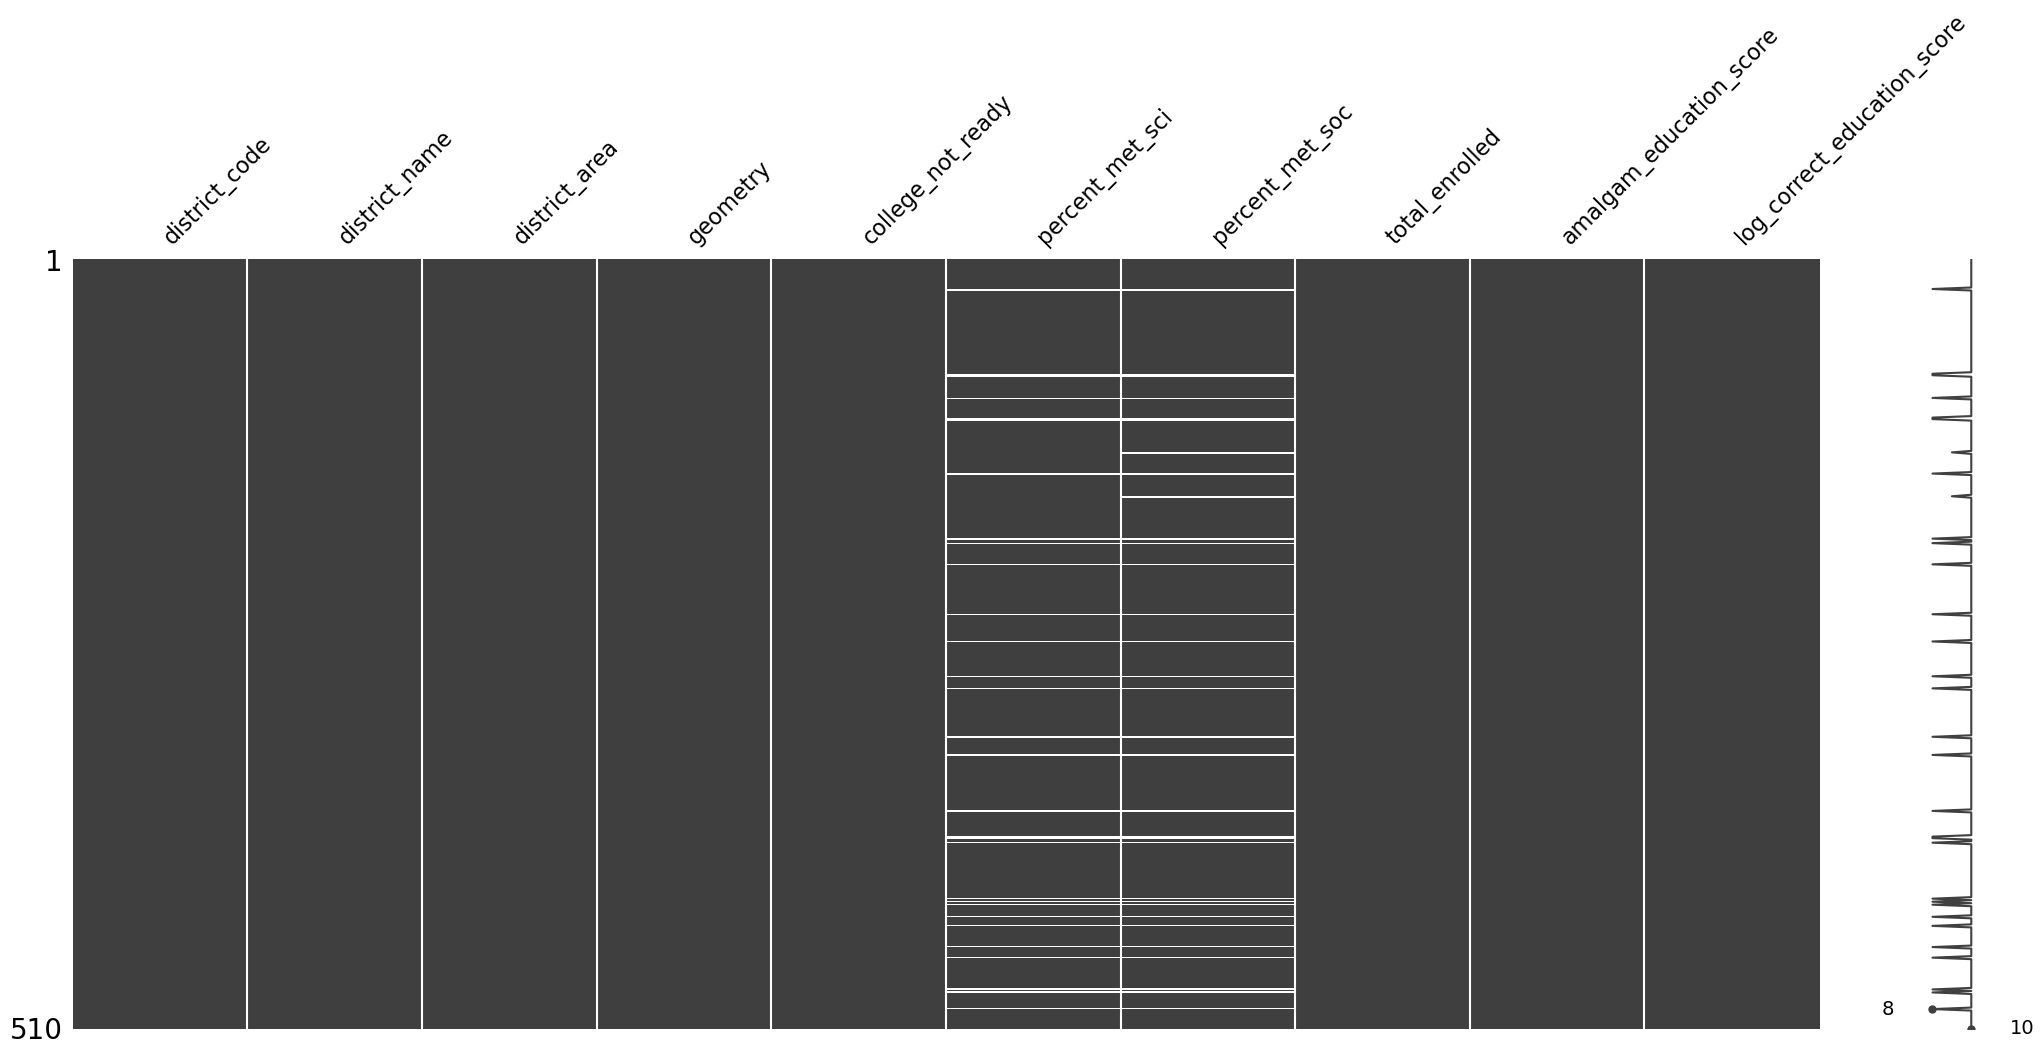

In [25]:
if regenerate_charts == True:
    msno.matrix(df_district)

### 3b) Variable distributions

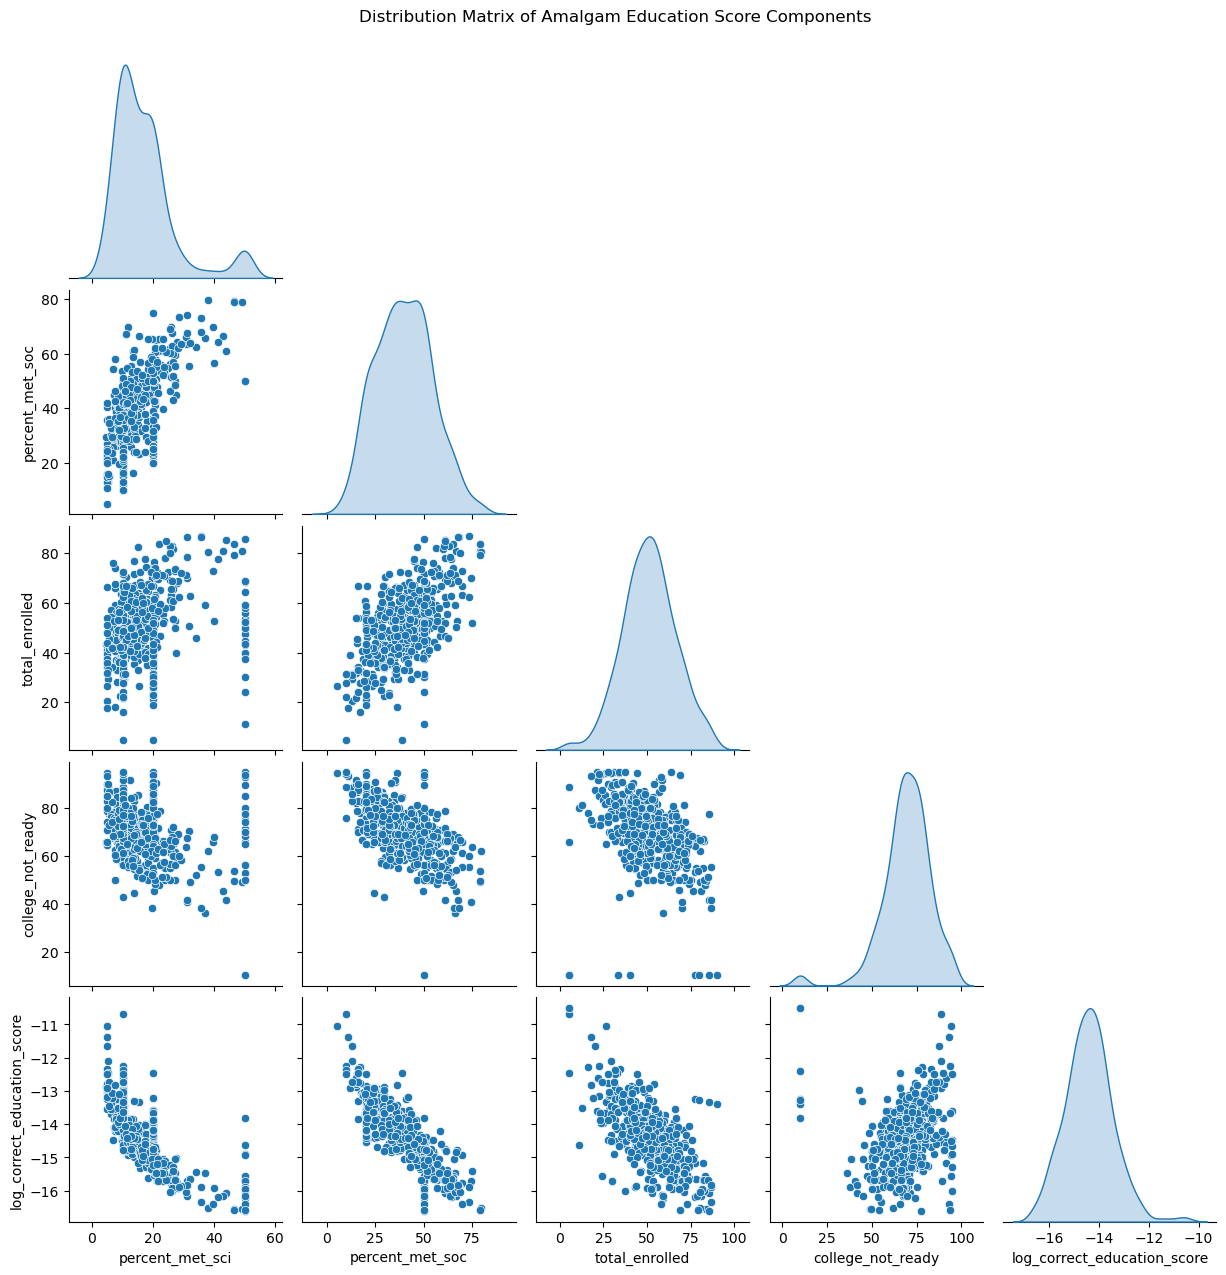

In [27]:
columns_to_plot = ['percent_met_sci', 'percent_met_soc', 'total_enrolled', 'college_not_ready','log_correct_education_score']
sns.pairplot(df_district[columns_to_plot], diag_kind='kde', corner=True)
plt.suptitle("Distribution Matrix of Amalgam Education Score Components", y=1.02)
plt.show()

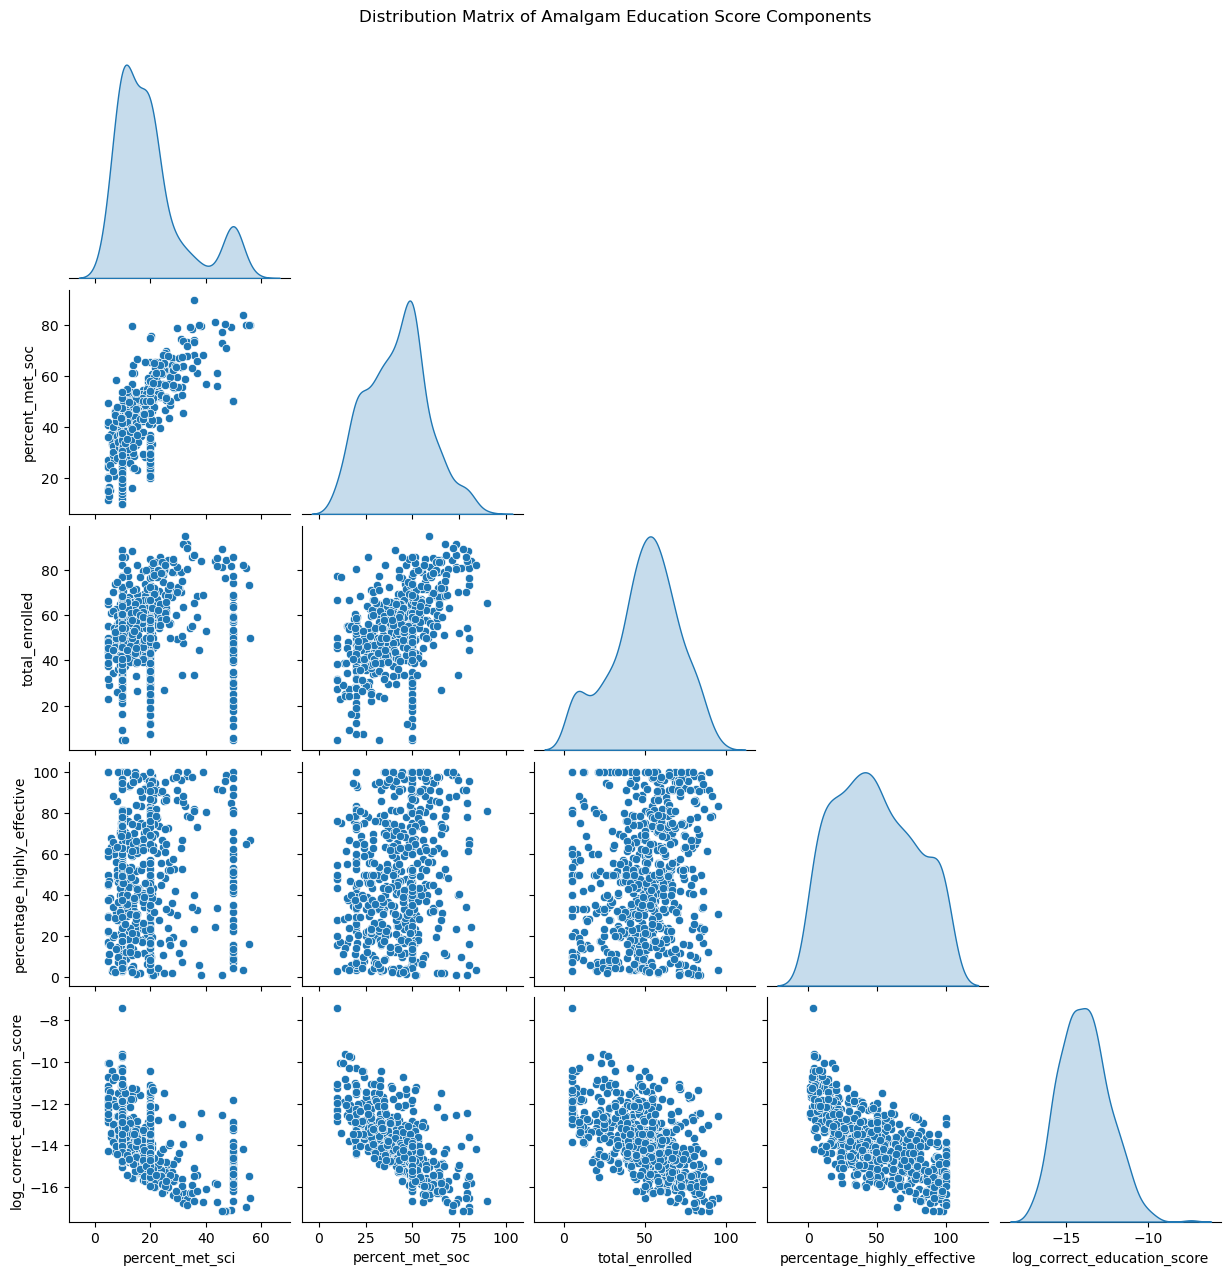

In [19]:
columns_to_plot = ['percent_met_sci', 'percent_met_soc', 'total_enrolled', 'percentage_highly_effective','log_correct_education_score']
sns.pairplot(df_school[columns_to_plot], diag_kind='kde', corner=True)
plt.suptitle("Distribution Matrix of Amalgam Education Score Components", y=1.02)
plt.show()

# Test 

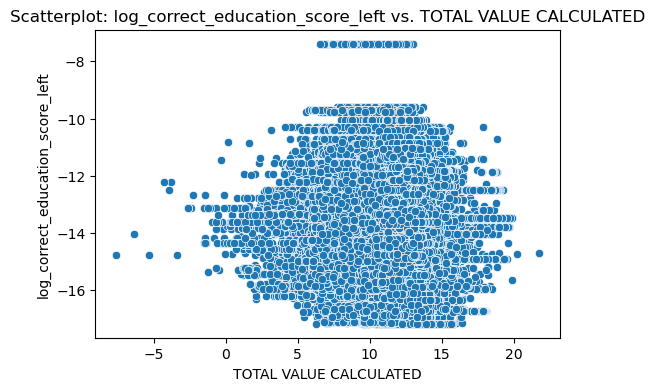

In [25]:
edu_col = "log_correct_education_score_left"
plt.figure(figsize=(6, 4))
sns.scatterplot(y=df_parcel[edu_col], x=np.log(df_parcel["total_value_calculated"]/df_parcel["size_parcel"]))
plt.ylabel(edu_col)
plt.xlabel("TOTAL VALUE CALCULATED")
plt.title(f"Scatterplot: {edu_col} vs. TOTAL VALUE CALCULATED")
plt.show()

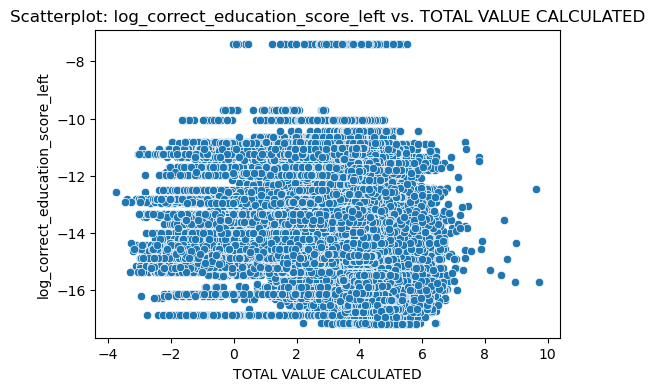

In [26]:
edu_col = "log_correct_education_score_left"
plt.figure(figsize=(6, 4))
sns.scatterplot(y=df_parcel[edu_col], x=np.log(df_parcel["total_value_calculated"]/df_parcel["size_living"]))
plt.ylabel(edu_col)
plt.xlabel("TOTAL VALUE CALCULATED")
plt.title(f"Scatterplot: {edu_col} vs. TOTAL VALUE CALCULATED")
plt.show()

In [32]:
df_parcel_sample = df_parcel.dropna().sample(n = 500000, random_state = random_state)

In [35]:

# Define independent variables (X) and dependent variable (y)
X = df_parcel_sample[['distance', 'log_correct_education_score_left', 'log_correct_education_score__dist', 'block_level_longitude', 'block_level_latitude']]
y = np.log(df_parcel_sample["total_value_calculated"]/df_parcel_sample["size_parcel"])

# Apply log transformation to the target variable to reduce skewness
y_logged = np.log1p(y)  # log(1 + y) to handle zeros safely

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_logged, test_size=0.2, random_state=42)

# Initialize and train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_logged = rf_model.predict(X_test)

# Reverse the log transformation to get predictions in original scale
y_pred = np.expm1(y_pred_logged)  # Inverse of log(1 + y)

# Reverse transformation for actual values
y_actual = np.expm1(y_test)

# Evaluate the model
r2 = r2_score(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))

# Print results
print("Random Forest Regression with Log Transformed Target")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Random Forest Regression with Log Transformed Target
R² Score: 0.7803
Mean Absolute Error (MAE): 0.3487
Root Mean Squared Error (RMSE): 0.5861


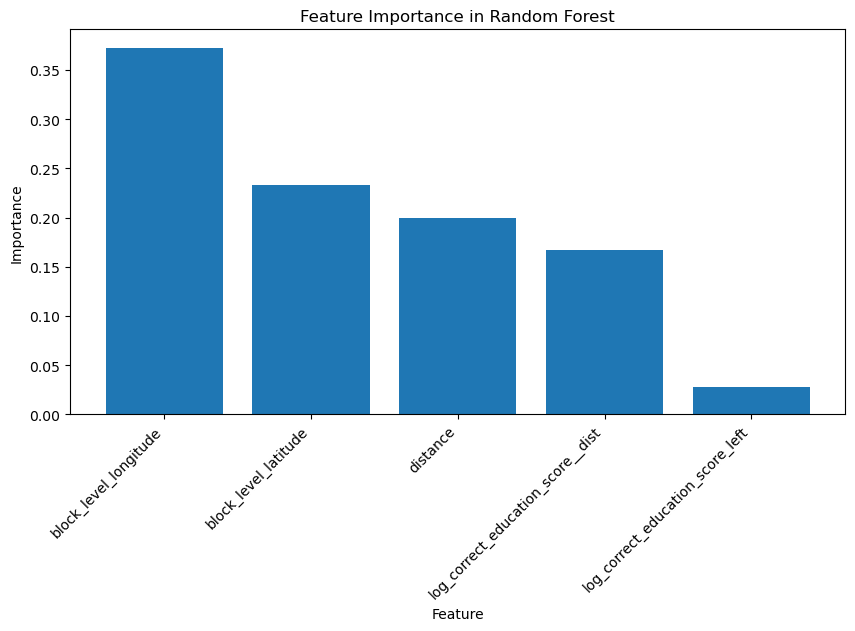

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = rf_model.feature_importances_

# Get feature names
feature_names = X.columns

# Sort feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), feature_names[sorted_indices], rotation=45, ha='right')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance in Random Forest")
plt.show()


In [ ]:
from sklearn.inspection import plot_partial_dependence

plot_partial_dependence(rf_model, X_test, features=["block_level_longitude", "distance"])
plt.show()